In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Import Libraries

# Azure Data Lake libraries
import common.utils.azure_data_lake_interface as adl

# config libraries
import common.config
from common.utils.configuration_management import load_config

# Data analysis libraries
import pandas as pd

In [3]:
def find_declining_margins(
    df: pd.DataFrame,
    days: int,
    tolerance: float = 0.0,
    date_col: str = "created_date",
    sku_col: str = "sku",
    gpp_col: str = "gross_profit_percent",
    trans_id_col: str = "tranid",
) -> pd.DataFrame:

    """
    Identifies products with declining gross profit margins within a specified time window.

    This function takes transaction data, computes the decline in gross profit percent for
    each SKU over a specified period, and filters for transactions where this decline
    exceeds a provided tolerance level. The final result is returned as a subset DataFrame
    meeting these criteria.

    Args:
        df (pd.DataFrame): Input DataFrame containing transactional data with gross profit
            percent and dates of transactions.
        days (int): Number of days to consider for the cutoff window. Only transactions
            within this number of days from the latest transaction date are considered.
        tolerance (float, optional): Minimum difference between the previous gross profit
            percentage and the current one to qualify as a "decline". Default is 0.0.
        date_col (str, optional): Name of the column in the DataFrame representing the
            transaction dates. Default is "created_date".
        sku_col (str, optional): Name of the column in the DataFrame identifying the
            stock keeping unit (SKU). Default is "sku".
        gpp_col (str, optional): Name of the column in the DataFrame representing the
            gross profit percentage (GPP). Default is "gross_profit_percent".
        trans_id_col (str, optional): Name of the column in the DataFrame representing the
            transaction identifier. Default is "tranid".

    Returns:
        pd.DataFrame: A subset of the input DataFrame containing rows where the gross profit
        percentage for a product has declined by more than the specified tolerance within
        the defined time window. The returned DataFrame includes columns for the current
        and previous gross profit percentages, transaction dates, and transaction IDs.
    """

    df = df.copy()

    # 1. Parse and sort
    df[date_col] = pd.to_datetime(df[date_col], errors='raise')
    df = df.sort_values([sku_col, date_col])

    # 2. Compute the prior-value column
    df['prev_gpp'] = df.groupby(sku_col)[gpp_col].shift(1)
    df['prev_trans_date'] = df.groupby(sku_col)[date_col].shift(1)
    df['prev_trans_id'] = df.groupby(sku_col)[trans_id_col].shift(1).fillna(0).astype(int)

    # 3. Compute cutoff
    cutoff = df['created_date'].max() - pd.Timedelta(days=days)

    # 4. Filter: within window AND declined
    mask_window   = df[date_col] >= cutoff
    mask_declined = (df["prev_gpp"] - df[gpp_col]) > tolerance
    result = df[mask_window & mask_declined]

    return result

In [4]:
# attach to the data lake
config = load_config(common.config, "datalake_config.json")
service_client = adl.get_azure_service_client(config["blob_url"])
file_system_client = adl.get_azure_file_system_client(service_client, "consolidated")

# get data
data_state = "enhanced"
trans_type = "Estimate"
filename = f"transaction/{trans_type}ItemLineItems_{data_state}.parquet"
est_lines_df = adl.get_parquet_file_from_data_lake(file_system_client, f"{data_state}/netsuite", filename)
saved_est_lines_df = est_lines_df.copy()

trans_type = "CustInvc"
filename = f"transaction/{trans_type}ItemLineItems_{data_state}.parquet"
inv_lines_df = adl.get_parquet_file_from_data_lake(file_system_client, f"{data_state}/netsuite", filename)
saved_inv_lines_df = inv_lines_df.copy()

In [ ]:
est_lines_df = saved_est_lines_df.copy()
inv_lines_df = saved_inv_lines_df.copy()

In [5]:
inv_lines_df

,created_date,created_from,entered_by,ai_order_type,commission_or_mfr_direct,id,tranid,sku,item_type,vsi_item_category,...,highest_quoted_cost,highest_recent_cost,highest_cost,handling_cost,labor_hours,unit_price,total_cost,total_amount,gross_profit,gross_profit_percent
0,2022-01-04,Sales Order #285216,ASIS Integration,Not Specified,False,28133677,328706,1317783,Non-inventory Item,Not Specified,...,0.00,0.0,0.00,0.00,0.0,3804.00,0.0,3804.00,3804.00,100.00
1,2022-01-04,Sales Order #285216,ASIS Integration,Not Specified,False,28133679,328706,1317784,Non-inventory Item,Not Specified,...,0.00,0.0,0.00,0.00,0.0,3187.00,0.0,3187.00,3187.00,100.00
2,2022-01-04,Sales Order #287196,Scott Gonzales,Not Specified,False,28132742,328704,1358178,Inventory Item,Pneumatic Control Valve,...,4351.00,4351.0,4351.00,43.51,0.0,5118.85,4351.0,5118.85,767.85,15.00
3,2022-01-04,Sales Order #287196,Scott Gonzales,Not Specified,False,28132745,328704,845097,Inventory Item,Valve Positioners/Controllers,...,1704.00,1704.0,1704.00,20.58,0.0,2005.00,1704.0,2005.00,301.00,15.01
4,2022-01-04,Sales Order #287196,Scott Gonzales,Not Specified,False,28132746,328704,1306056,Inventory Item,Mounting Hardware,...,320.00,320.0,320.00,3.42,0.0,377.00,320.0,377.00,57.00,15.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355932,2025-04-30,Sales Order #436798,Nicole Duncomb,Not Specified,False,45306186,513490,36460,Service,Not Specified,...,580.00,0.0,580.00,0.00,0.0,1914.00,309.0,1914.00,1605.00,83.86
355933,2025-04-30,Sales Order #436798,Nicole Duncomb,Not Specified,False,45306187,513490,12032,Inventory Item,Not Specified,...,99.00,99.0,99.00,1.80,0.0,152.00,99.0,152.00,53.00,34.87
355934,2025-04-30,Sales Order #436828,Nicole Duncomb,Not Specified,False,45306179,513489,36458,Service,Not Specified,...,1246.99,0.0,1246.99,0.00,0.0,1747.00,263.0,1747.00,1484.00,84.95
355935,2025-04-30,Sales Order #436828,Nicole Duncomb,Not Specified,False,45306180,513489,2921270,Non-inventory Item,Not Specified,...,650.00,650.0,650.00,19.50,0.0,1000.00,650.0,1000.00,350.00,35.00


In [6]:
lookback = 10
source = "estimate"
df = est_lines_df if source == "estimate" else inv_lines_df
margin_declines = find_declining_margins(df, days=lookback)
margin_declines

,created_date,created_from,entered_by,ai_order_type,commission_or_mfr_direct,id,tranid,sku,item_type,vsi_item_category,...,handling_cost,labor_hours,unit_price,total_cost,total_amount,gross_profit,gross_profit_percent,prev_gpp,prev_trans_date,prev_trans_id
343313,2025-04-22,Not Specified,Antonio Penaherrera,Not Specified,False,45195049,302413,114,Inventory Item,Not Specified,...,2.82,0.00,111.00,61.00,111.00,50.00,45.05,48.88,2025-01-22,287460
346149,2025-04-29,Not Specified,Jeffrey A Diercks,Not Specified,False,45287993,303586,127,Inventory Item,Not Specified,...,142.44,0.00,6463.00,3877.56,6463.00,2585.44,40.00,40.01,2025-02-04,289934
345427,2025-04-25,Not Specified,Stacie Comia,Not Specified,False,45260521,303294,176,Inventory Item,Not Specified,...,24.81,0.42,275.71,202.62,275.71,73.09,26.51,41.63,2025-01-15,286298
345424,2025-04-25,Not Specified,Stacie Comia,Not Specified,False,45260508,303292,239,Inventory Item,Not Specified,...,4.83,0.00,127.05,79.56,127.05,47.49,37.38,46.80,2025-03-12,296039
344469,2025-04-24,Not Specified,Frank Comia,Not Specified,False,45236876,302913,272,Inventory Item,Not Specified,...,17.34,0.00,648.00,365.86,648.00,282.14,43.54,46.15,2025-04-07,300108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344281,2025-04-24,Not Specified,Sean DeGeest,Manufacturer Direct,True,45232348,302845,2938866,Non-inventory Item,Not Specified,...,132.66,0.00,4422.00,8844.00,8844.00,0.00,0.00,100.00,2025-03-21,297829
346206,2025-04-29,Not Specified,Sean DeGeest,Manufacturer Direct,True,45288168,303590,2940494,Non-inventory Item,Not Specified,...,66.00,0.00,2200.00,2200.00,2200.00,0.00,0.00,100.00,2025-04-17,302005
346456,2025-04-29,Not Specified,John Witek,Not Specified,False,45300614,303725,2945208,Non-inventory Item,Not Specified,...,34.72,0.00,1601.50,2314.98,3203.00,888.02,27.72,30.69,2025-04-22,302539
343832,2025-04-23,Not Specified,Cathryn L Hindman,Not Specified,False,45251796,302643,2949309,Assembly/Bill of Materials,Not Specified,...,77.28,0.00,1872.00,1300.08,1872.00,571.92,30.55,32.92,2025-04-23,302643


In [7]:
margin_declines.to_excel(f'../excel_outputs/{source}_line_item_margin_declines_in_past_{lookback}_days.xlsx', index=False)

In [8]:
inv_lines_df['Month'] = inv_lines_df["created_date"].dt.to_period('M')

In [38]:
plot_data = inv_lines_df[(inv_lines_df.total_cost > 0) &
                         (inv_lines_df.gross_profit_percent != float('-inf')) &
                         (inv_lines_df.gross_profit_percent >= -50) &
                         (inv_lines_df.subsidiary_name != "Not Specified")
].copy()

In [14]:
monthly_margin_by_subsidiary = plot_data.groupby(['Month', 'subsidiary_name']).agg(
    avg_margin_pct=('gross_profit_percent', 'mean')
)

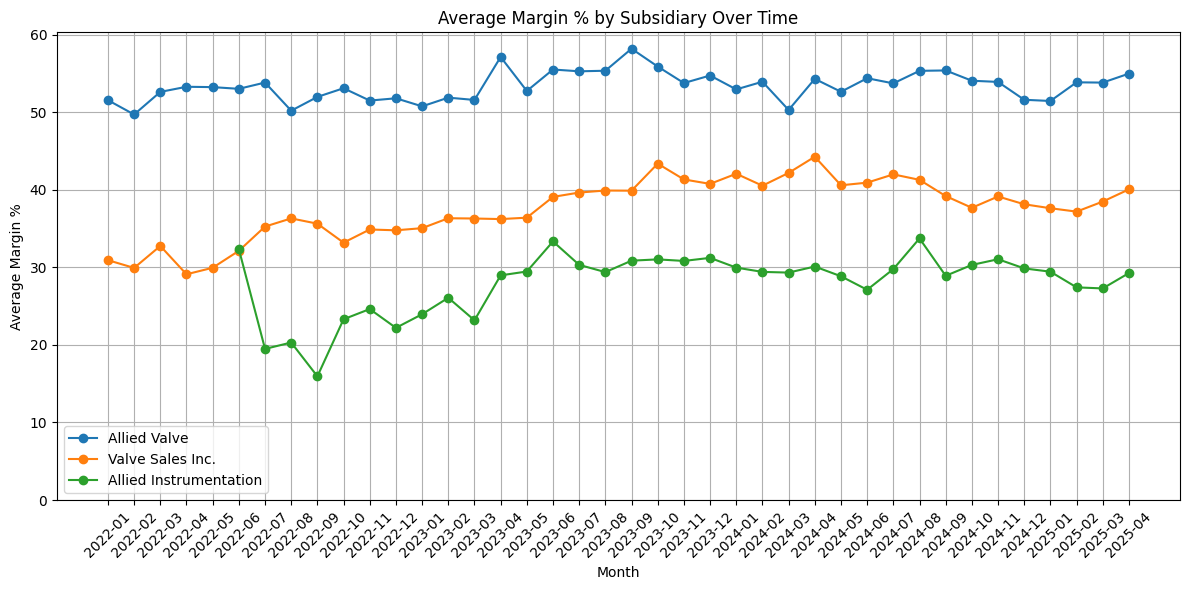

In [15]:
import matplotlib.pyplot as plt

# Reset index to convert Month from index to column
chart_data = monthly_margin_by_subsidiary.reset_index()

# Create figure and plot lines
plt.figure(figsize=(12, 6))
for subsidiary in chart_data['subsidiary_name'].unique():
    subsidiary_data = chart_data[chart_data['subsidiary_name'] == subsidiary]
    plt.plot(subsidiary_data['Month'].astype(str),
             subsidiary_data['avg_margin_pct'],
             marker='o',
             label=subsidiary)

plt.xlabel('Month')
plt.ylabel('Average Margin %')
plt.title('Average Margin % by Subsidiary Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.ylim(bottom=0)  # Set y-axis to start at 0
plt.tight_layout()

In [32]:
weighted_margin = plot_data.groupby(['Month', 'subsidiary_name']).agg(
    total_costs=('total_cost', 'sum'),
    total_revenues=('total_amount', 'sum'),
).assign(
    weighted_margin=lambda x: round((x.total_revenues - x.total_costs) * 100 / x.total_revenues, 2)
)

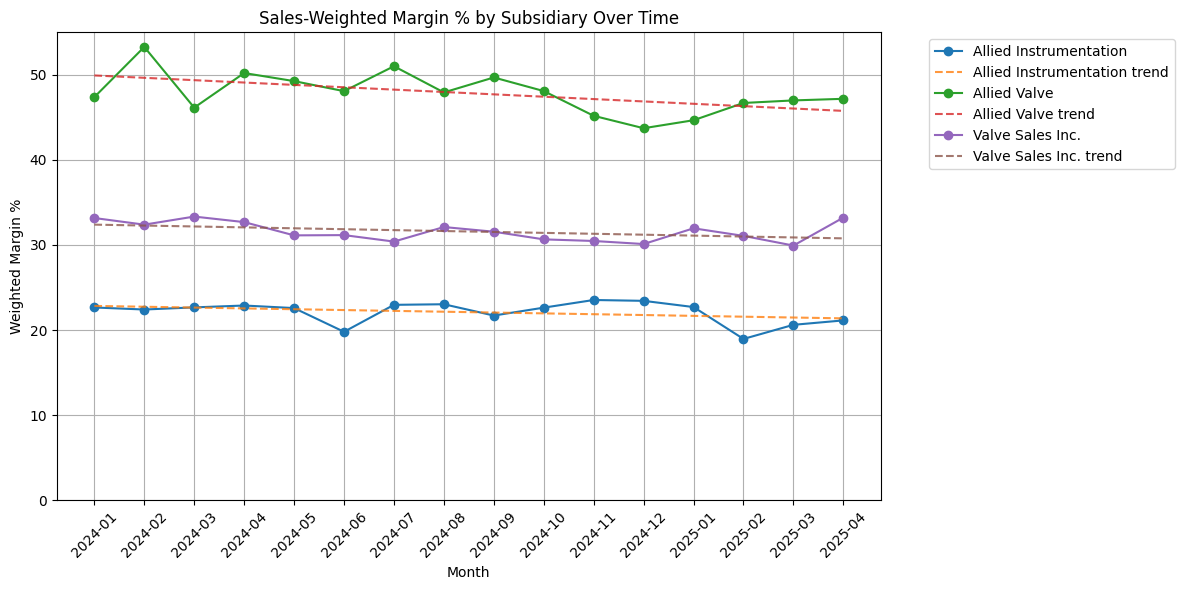

In [33]:
import numpy as np

# Reset index to convert Month from index to column
chart_data = weighted_margin.reset_index()

# restrict data to specific window
start_date = '2024-01'
chart_data = chart_data[chart_data['Month'] >= start_date]

plt.figure(figsize=(12, 6))
for subsidiary in chart_data['subsidiary_name'].unique():
    subsidiary_data = chart_data[chart_data['subsidiary_name'] == subsidiary]

    # Convert Month to numeric values for trend line
    x = range(len(subsidiary_data))
    y = subsidiary_data['weighted_margin'].values

    # Calculate trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)

    # Plot actual data and trend line
    plt.plot(subsidiary_data['Month'].astype(str),
             subsidiary_data['weighted_margin'],
             marker='o',
             label=subsidiary)
    plt.plot(subsidiary_data['Month'].astype(str),
             p(x),
             '--',
             alpha=0.8,
             label=f'{subsidiary} trend')

plt.xlabel('Month')
plt.ylabel('Weighted Margin %')
plt.title('Sales-Weighted Margin % by Subsidiary Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()


In [19]:
monthly_price_cost = plot_data.groupby(['Month', 'subsidiary_name']).agg(
    total_costs=('total_cost', 'sum'),
    total_revenues=('total_amount', 'sum'),
    total_qty=('quantity', 'sum')
).assign(
    weighted_avg_unit_cost=lambda x: x.total_costs / x.total_qty,
    weighted_avg_unit_price=lambda x: x.total_revenues / x.total_qty
)

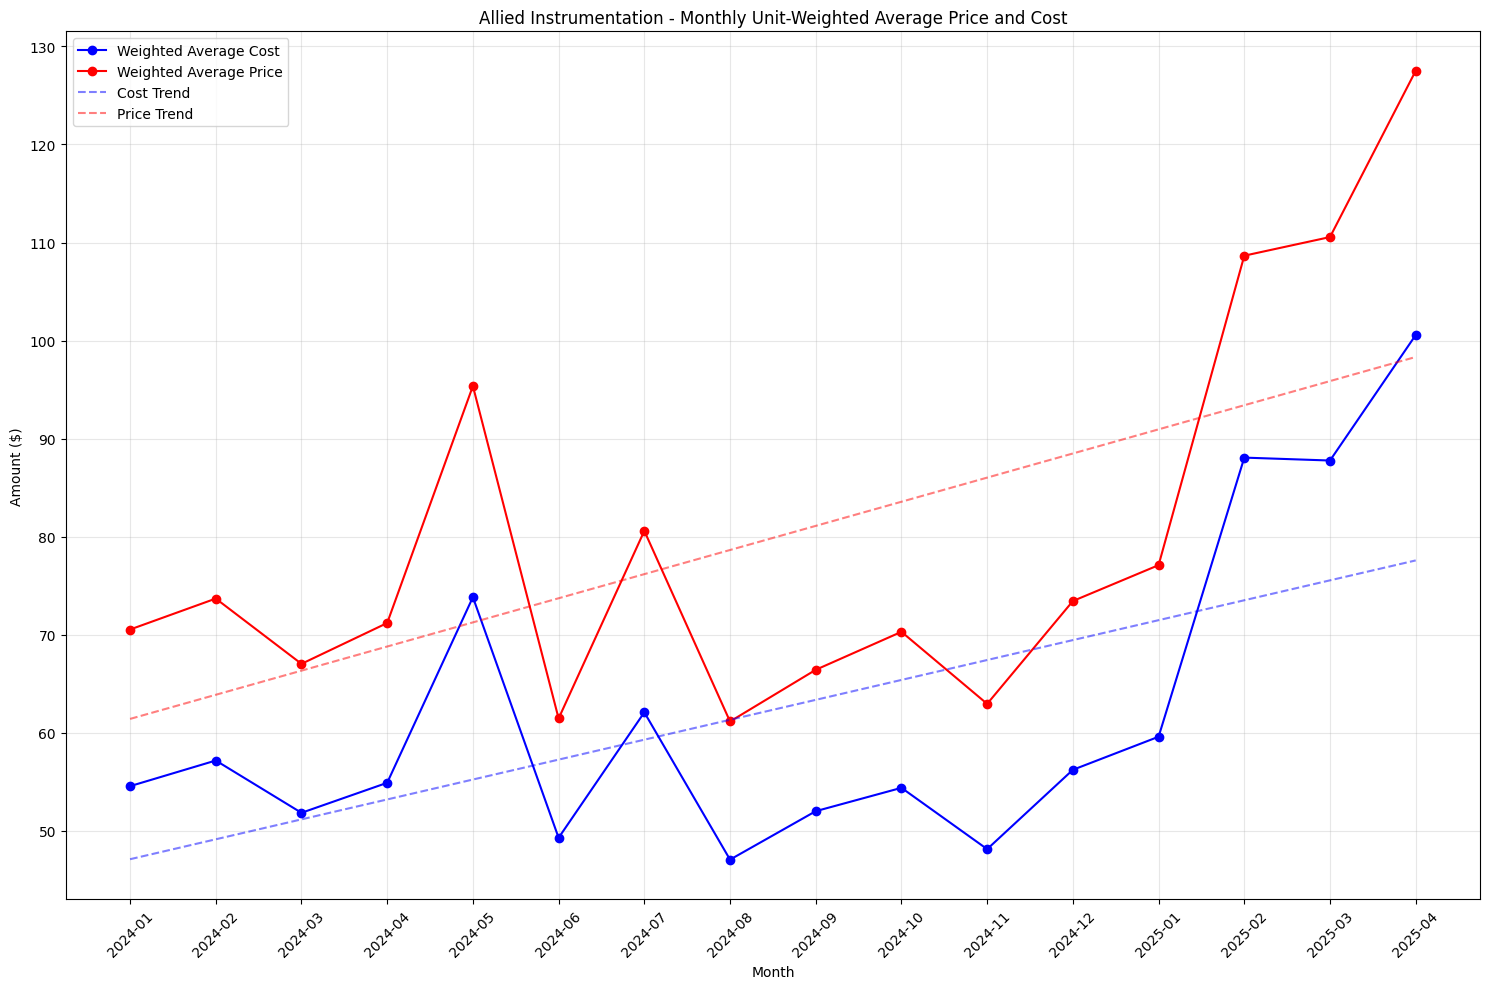

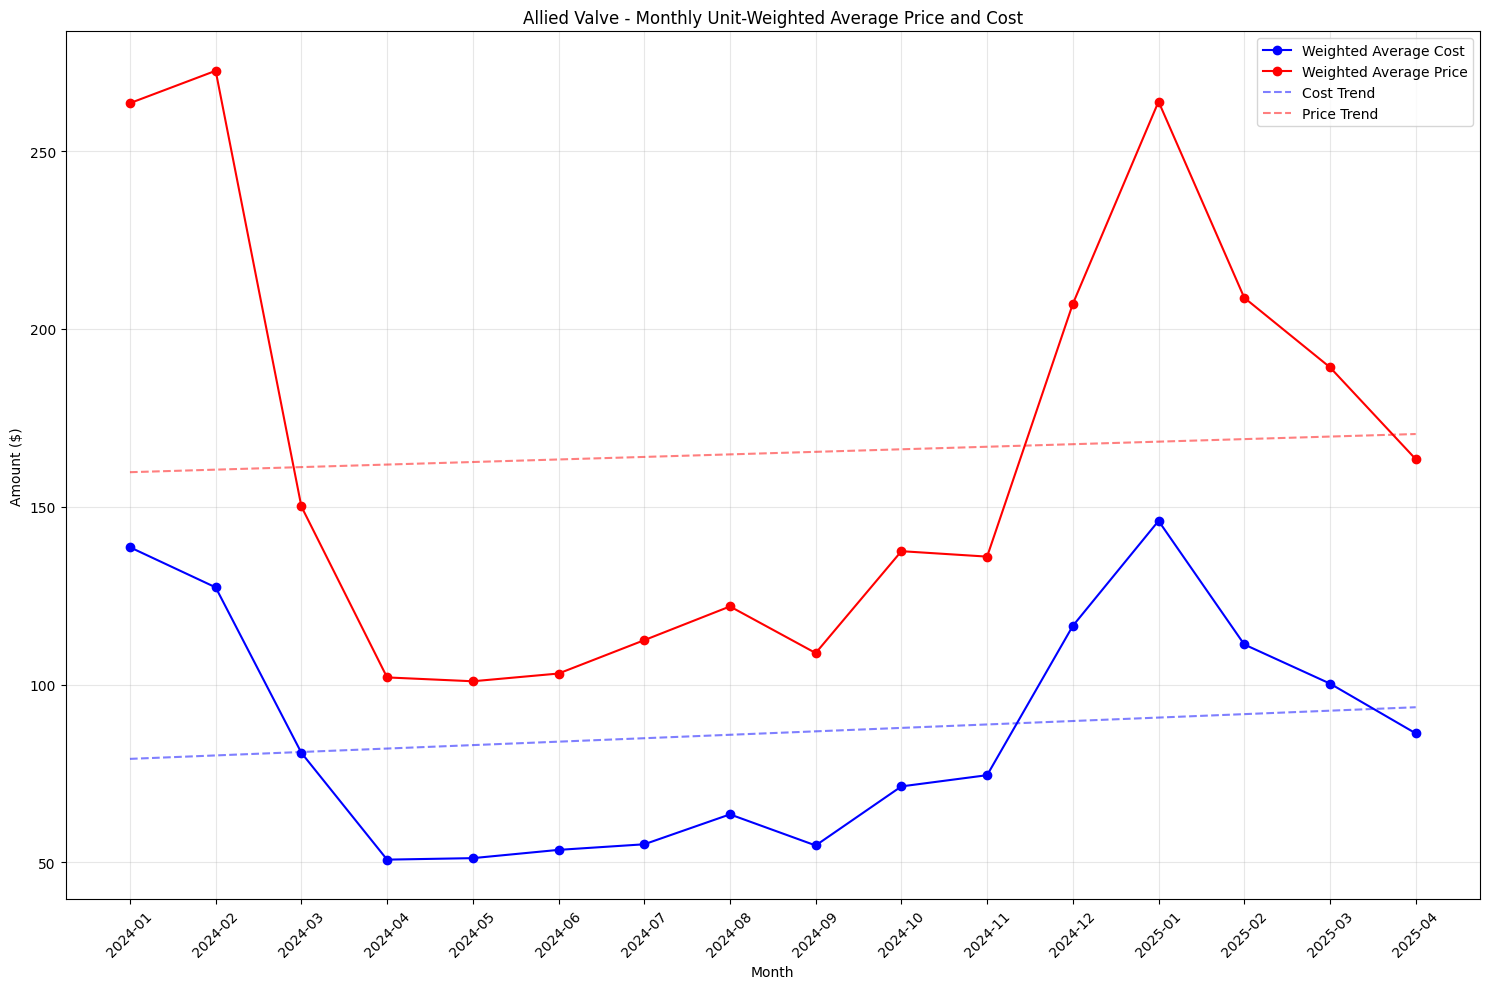

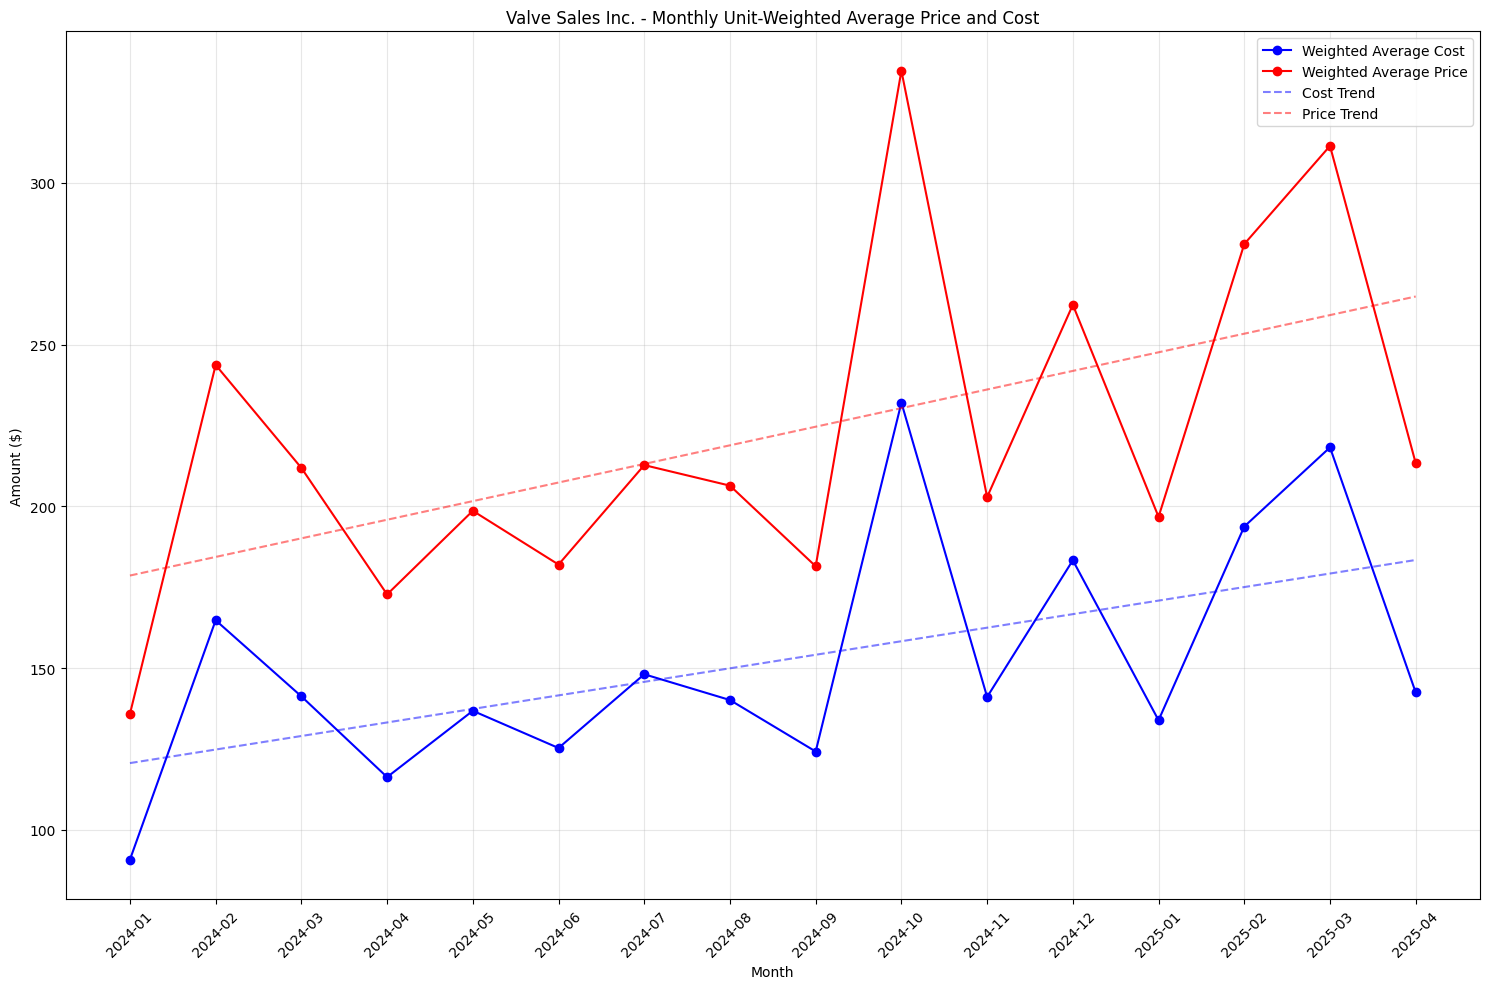

In [23]:
from scipy import stats

# Reset index to convert Month from index to column
chart_data = monthly_price_cost.reset_index()

# restrict data to specific window
start_date = '2024-01'
chart_data = chart_data[chart_data['Month'] >= start_date]

# Count number of subsidiaries
n_subsidiaries = len(chart_data['subsidiary_name'].unique())

# Create separate figure for each subsidiary
for subsidiary in plot_data['subsidiary_name'].unique():
    plt.figure(figsize=(15, 10))
    subsidiary_data = chart_data[chart_data['subsidiary_name'] == subsidiary]

    # Convert Month to numeric values for trend line
    x = range(len(subsidiary_data))

    # Plot actual data points
    plt.plot(subsidiary_data['Month'].astype(str),
             subsidiary_data['weighted_avg_unit_cost'],
             'bo-', label='Weighted Average Cost')
    plt.plot(subsidiary_data['Month'].astype(str),
             subsidiary_data['weighted_avg_unit_price'],
             'ro-', label='Weighted Average Price')

    # Calculate and plot trend lines
    slope_cost, intercept_cost, _, _, _ = stats.linregress(x, subsidiary_data['weighted_avg_unit_cost'])
    slope_price, intercept_price, _, _, _ = stats.linregress(x, subsidiary_data['weighted_avg_unit_price'])

    trend_cost = [slope_cost * i + intercept_cost for i in x]
    trend_price = [slope_price * i + intercept_price for i in x]

    plt.plot(subsidiary_data['Month'].astype(str), trend_cost, 'b--', alpha=0.5, label='Cost Trend')
    plt.plot(subsidiary_data['Month'].astype(str), trend_price, 'r--', alpha=0.5, label='Price Trend')

    plt.title(f'{subsidiary} - Monthly Unit-Weighted Average Price and Cost')
    plt.xlabel('Month')
    plt.ylabel('Amount ($)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout();

In [39]:
plot_data['highest_total_cost'] = plot_data['quantity'] * plot_data['highest_cost']

In [26]:
monthly_price_cost = plot_data.groupby(['Month', 'subsidiary_name']).agg(
    total_costs=('highest_total_cost', 'sum'),
    total_revenues=('total_amount', 'sum'),
    total_qty=('quantity', 'sum')
).assign(
    weighted_avg_unit_cost=lambda x: x.total_costs / x.total_qty,
    weighted_avg_unit_price=lambda x: x.total_revenues / x.total_qty
)

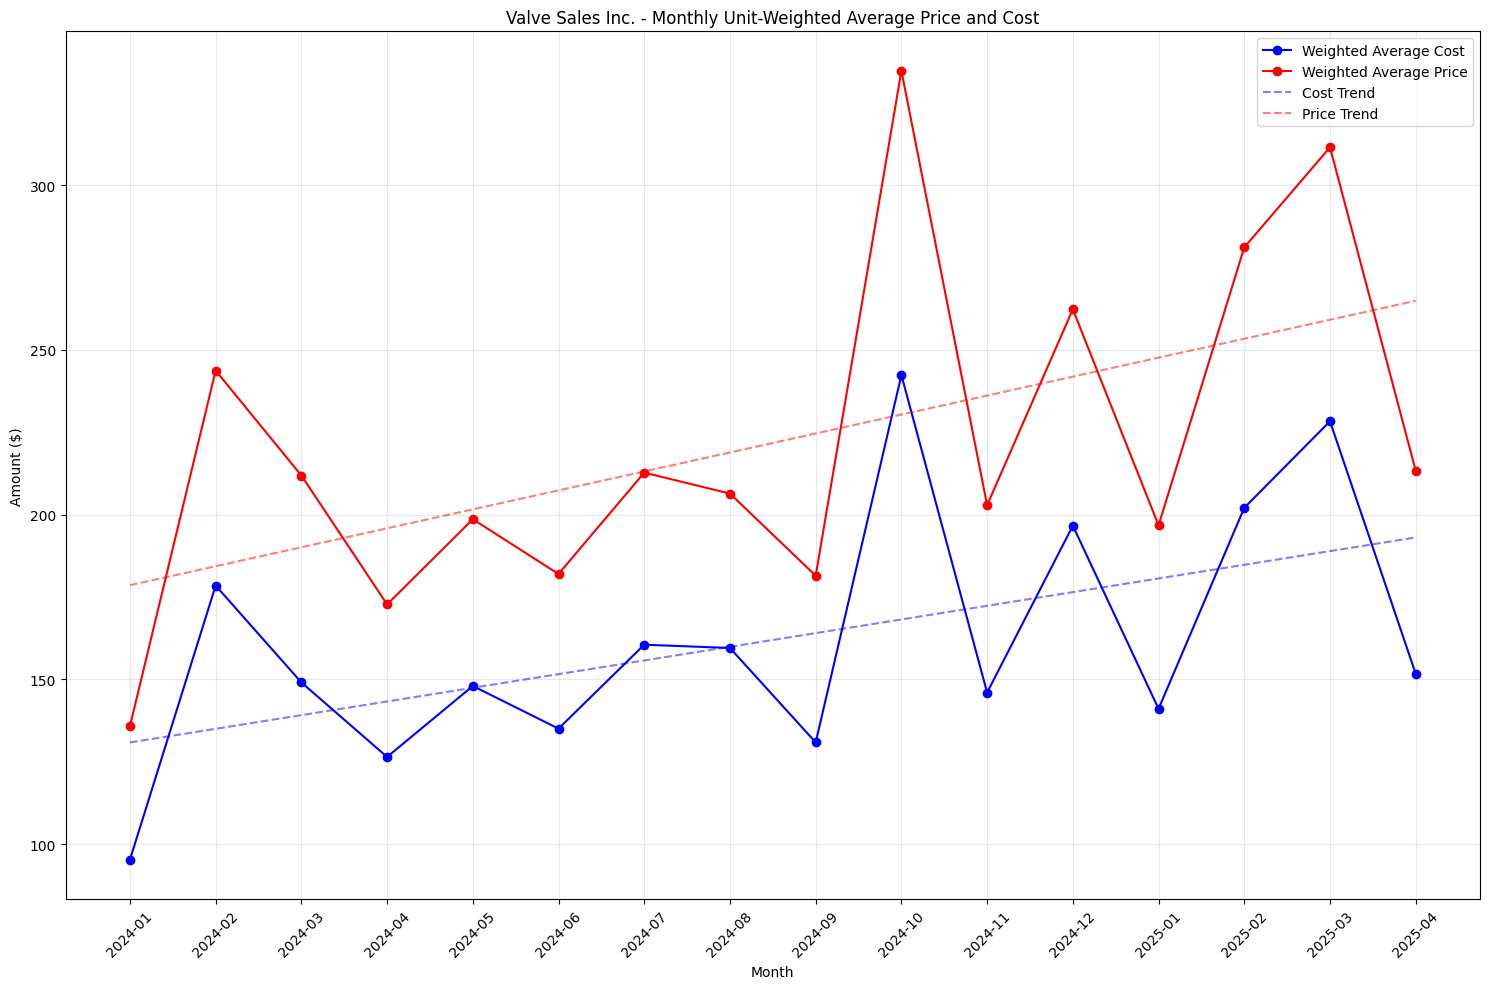

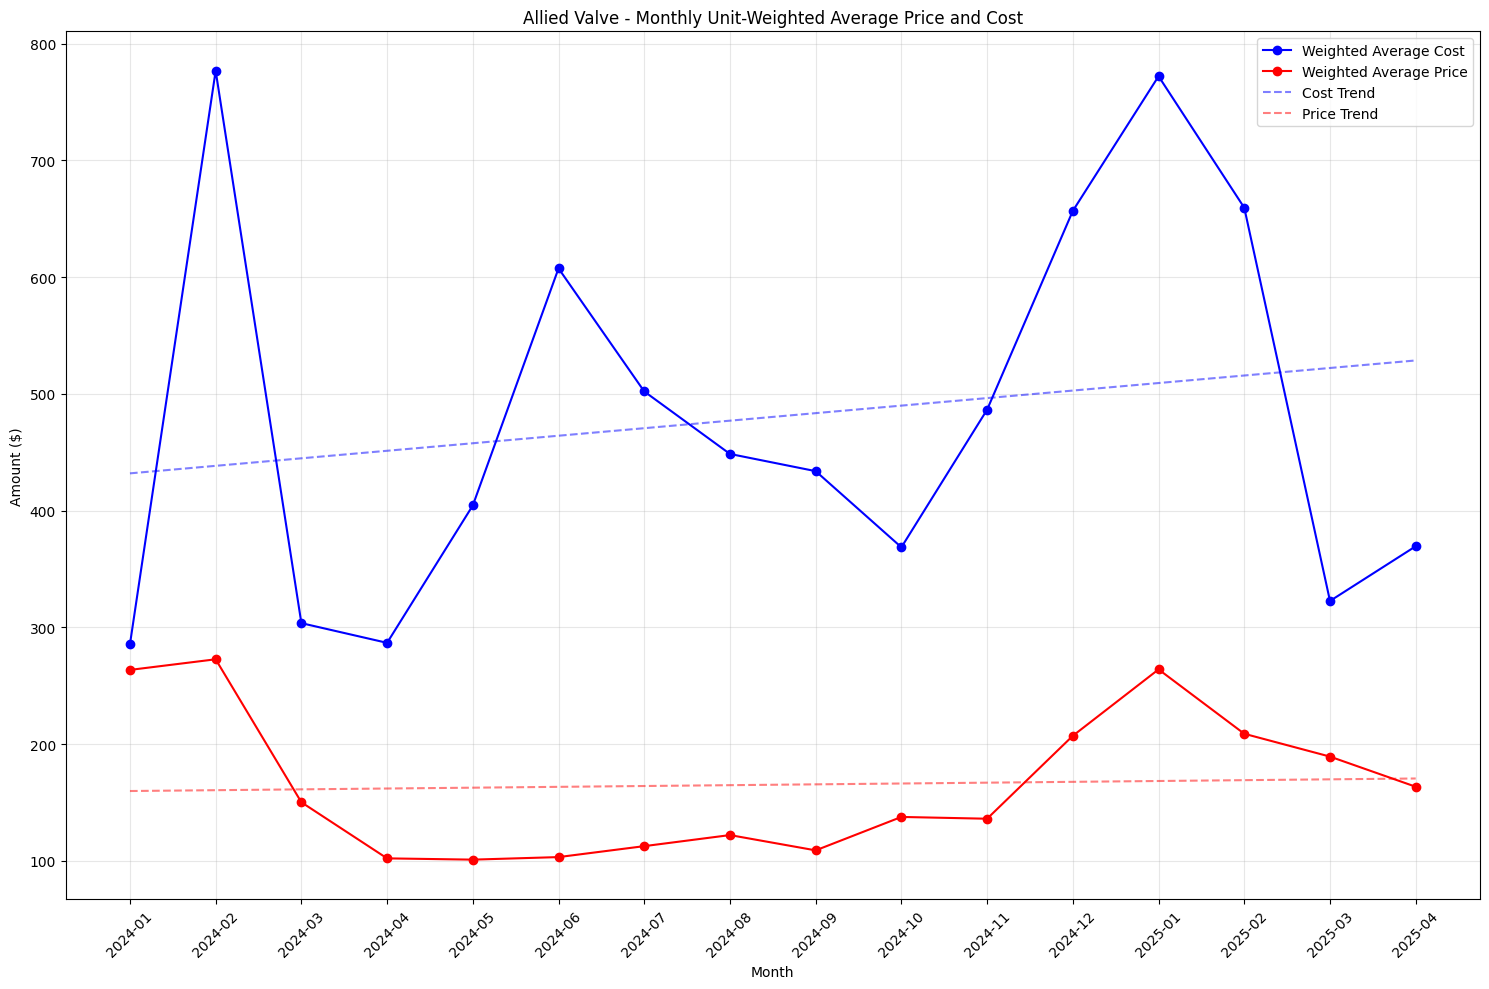

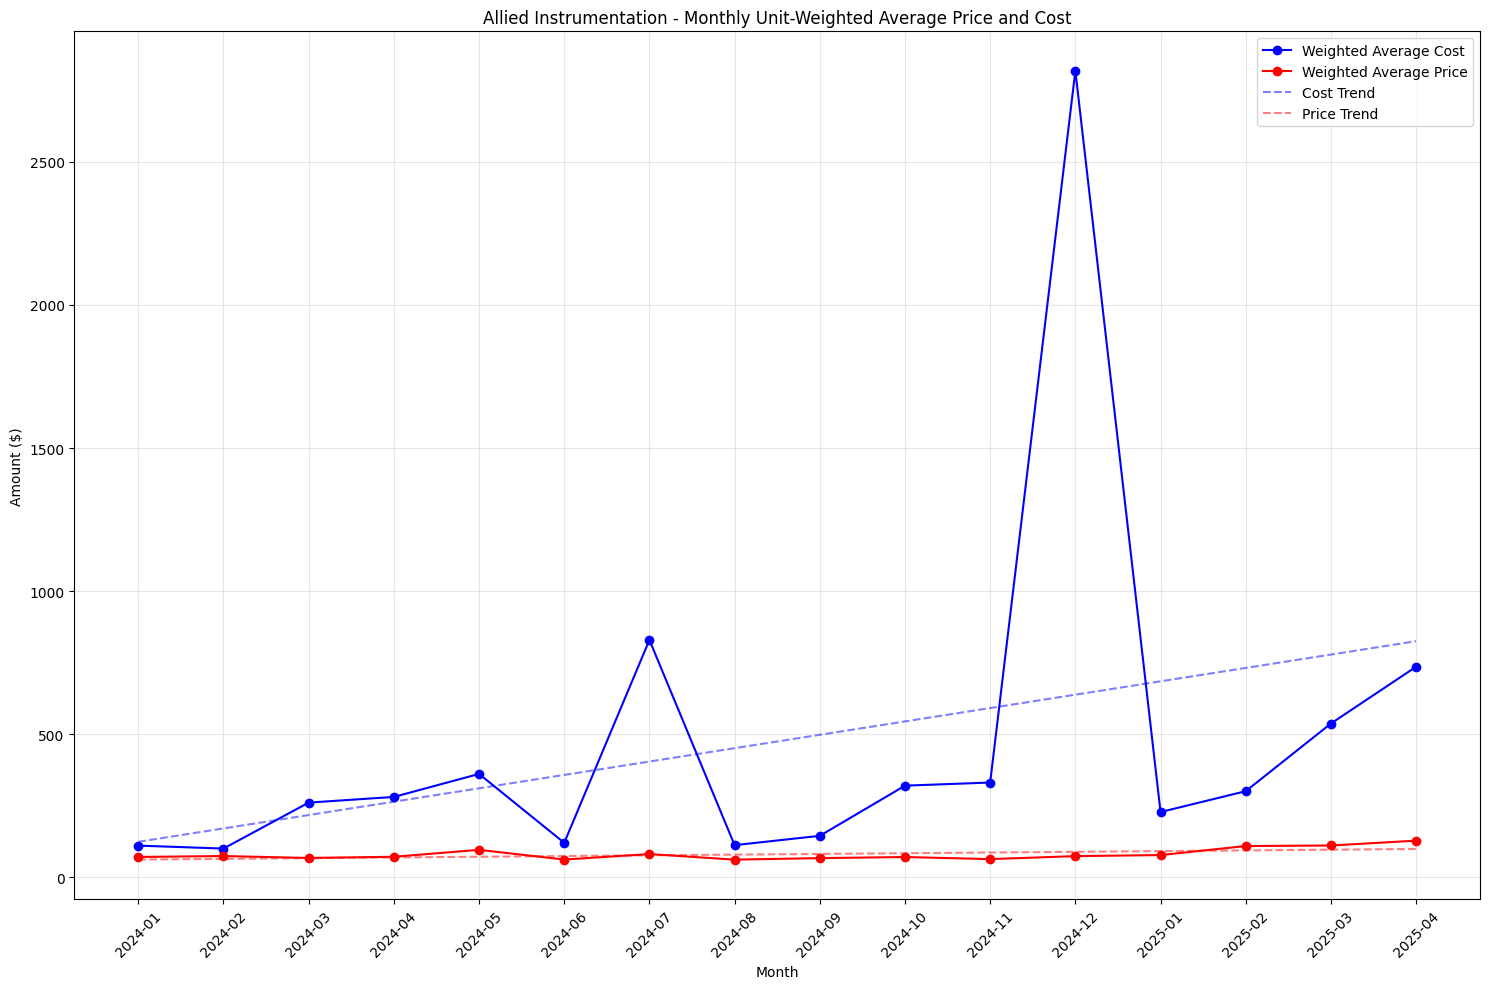

In [27]:
# Reset index to convert Month from index to column
chart_data = monthly_price_cost.reset_index()

# restrict data to specific window
start_date = '2024-01'
chart_data = chart_data[chart_data['Month'] >= start_date]

# Count number of subsidiaries
n_subsidiaries = len(chart_data['subsidiary_name'].unique())

# Create separate figure for each subsidiary
for subsidiary in plot_data['subsidiary_name'].unique():
    plt.figure(figsize=(15, 10))
    subsidiary_data = chart_data[chart_data['subsidiary_name'] == subsidiary]

    # Convert Month to numeric values for trend line
    x = range(len(subsidiary_data))

    # Plot actual data points
    plt.plot(subsidiary_data['Month'].astype(str),
             subsidiary_data['weighted_avg_unit_cost'],
             'bo-', label='Weighted Average Cost')
    plt.plot(subsidiary_data['Month'].astype(str),
             subsidiary_data['weighted_avg_unit_price'],
             'ro-', label='Weighted Average Price')

    # Calculate and plot trend lines
    slope_cost, intercept_cost, _, _, _ = stats.linregress(x, subsidiary_data['weighted_avg_unit_cost'])
    slope_price, intercept_price, _, _, _ = stats.linregress(x, subsidiary_data['weighted_avg_unit_price'])

    trend_cost = [slope_cost * i + intercept_cost for i in x]
    trend_price = [slope_price * i + intercept_price for i in x]

    plt.plot(subsidiary_data['Month'].astype(str), trend_cost, 'b--', alpha=0.5, label='Cost Trend')
    plt.plot(subsidiary_data['Month'].astype(str), trend_price, 'r--', alpha=0.5, label='Price Trend')

    plt.title(f'{subsidiary} - Monthly Unit-Weighted Average Price and Cost')
    plt.xlabel('Month')
    plt.ylabel('Amount ($)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout();

In [36]:
from common.utils.data_cleansing import clean_illegal_chars_in_column

In [43]:
col = "description"
cleaned_series = clean_illegal_chars_in_column(plot_data, col)
cleaned_series = cleaned_series.iloc[:, 0]
plot_data[col] = cleaned_series

In [44]:
plot_data.to_csv(f'../excel_outputs/curated_{source}_line_item_data.csv', index=False)